In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

sn.set_style('whitegrid')
%matplotlib inline

In [3]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [4]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

In [4]:
path = "./other_data/"
tab_raw = pd.read_excel(path+'remote_work.xlsx')
tab_raw

,,Ambos sexos,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45
0,,Total,NaN,NaN,NaN,NaN,De 25 a 34 años,NaN,NaN,NaN,...,De 25 a 34 años,NaN,NaN,NaN,NaN,De 35 a 44 años,NaN,NaN,NaN,NaN
1,,Total,Ocasionalmente,Más de la mitad de los días que trabajó,Ningún día,No sabe,Total,Ocasionalmente,Más de la mitad de los días que trabajó,Ningún día,...,Total,Ocasionalmente,Más de la mitad de los días que trabajó,Ningún día,No sabe,Total,Ocasionalmente,Más de la mitad de los días que trabajó,Ningún día,No sabe
2,,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,...,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje,Porcentaje
3,2022,100,6.3,7.6,85.2,0.9,100,4.7,8,85.9,...,100,4.4,8.9,85.4,1.4,100,7.7,8.4,82.8,1
4,2021,100,5.8,9.5,83.9,0.8,100,4.3,10.6,83.7,...,100,4.2,10.7,83.6,1.5,100,6.9,10.9,81.1,1.1
5,2020,100,4.2,10.8,83.5,1.5,100,3.7,11.4,83,...,100,3.8,11.7,82.3,2.3,100,4.2,13.9,80.5,1.4
6,2019,100,3.5,4.8,90.7,1,100,2.9,3.5,92.5,...,100,2.4,3.3,92.8,1.5,100,3.8,4.7,90.4,1
7,2018,100,3.2,4.3,91.5,1,100,2.6,2.9,92.9,...,100,2.6,3.4,92.4,1.6,100,3.1,4.4,91.5,1
8,2017,100,3,4.3,91.8,1,100,2,3.3,93.3,...,100,1.7,3.6,93.1,1.5,100,2.7,4.2,92.4,0.7
9,2016,100,2.9,3.5,92.8,0.8,100,1.7,2.8,94.4,...,100,1.6,2.9,94.1,1.5,100,2.9,3.1,93,0.9


In [5]:
freq = tab_raw.iloc[1][1:6].values
age_groups = np.hstack((['Total'],tab_raw.iloc[0].unique()[-2:]))
sex_group = ['Total','Men',"Women"]

In [6]:
mx = pd.MultiIndex.from_product((sex_group,age_groups,freq))
tab= pd.DataFrame(tab_raw.iloc[3:,1:].values, columns=mx,index=tab_raw.iloc[3:,0])
tab = tab[::-1]
tab.head()

Total                                                                    \
     Total                                                                     
     Total Ocasionalmente Más de la mitad de los días que trabajó Ningún día   
                                                                               
2006   100            2.2                                       3       94.2   
2007   100            2.5                                     2.7       94.2   
2008   100            2.4                                     3.1         94   
2009   100            2.6                                     3.3       93.5   
2010   100            2.4                                     3.8       93.2   

                                             \
             De 25 a 34 años                  
     No sabe           Total Ocasionalmente   
                                              
2006     0.6             100            1.8   
2007     0.6             100            1.8   
2008     0.5             100              2   
2009     0.6             100            1.9   
2010     0.6             100            1.8   

                                                                 ...  \
                                                                 ...   
     Más de la mitad de los días que trabajó Ningún día No sabe  ...   
                                                                 ...   
2006                                     2.1       95.4     0.7  ...   
2007                                     1.7       95.7     0.8  ...   
2008                                     2.7       94.6     0.7  ...   
2009                                     2.2       95.3     0.7  ...   
2010                                     2.5         95     0.6  ...   

               Women                                                         \
     De 25 a 34 años                                                          
               Total Ocasionalmente Más de la mitad de los días que trabajó   
                                                                              
2006             100            1.7                                       2   
2007             100            1.7                                       2   
2008             100            2.1                                     2.7   
2009             100            1.6                                     2.1   
2010             100            1.8                                     2.9   

                                                        \
                        De 35 a 44 años                  
     Ningún día No sabe           Total Ocasionalmente   
                                                         
2006       95.6     0.7             100            2.2   
2007       95.3       1             100            2.7   
2008       94.6     0.6             100            2.3   
2009       95.6     0.7             100            2.4   
2010       94.6     0.7             100            2.3   

                                                                 
                                                                 
     Más de la mitad de los días que trabajó Ningún día No sabe  
                                                                 
2006                                     3.3       93.8     0.7  
2007                                     3.9         93     0.5  
2008                                     4.1       93.1     0.5  
2009                                     3.5       93.4     0.6  
2010                                     4.4       92.7     0.7  

[5 rows x 45 columns]

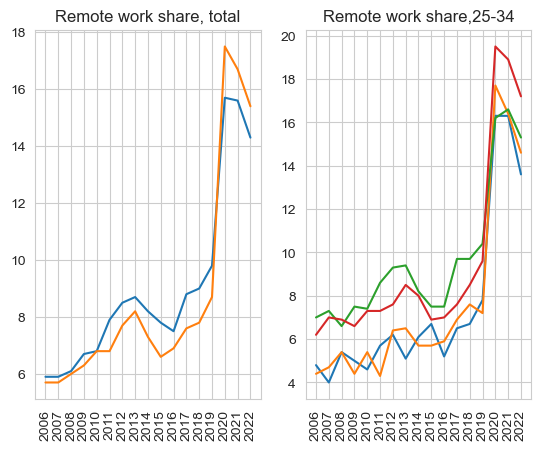

In [55]:
plt.subplot(121)
plt.plot(100-tab["Men",'Total',"Ningún día"],label='Men')
plt.plot(100-tab['Women',"Total","Ningún día"],label='Women')
plt.xticks(rotation=90)
plt.title('Remote work share, total')

plt.subplot(122)
plt.plot(100-tab["Men",'De 25 a 34 años',"Ningún día"],label='Men')
plt.plot(100-tab['Women',"De 25 a 34 años","Ningún día"],label='Women')

plt.plot(100-tab["Men",'De 35 a 44 años',"Ningún día"],label='Men')
plt.plot(100-tab['Women',"De 35 a 44 años","Ningún día"],label='Women')
plt.xticks(rotation=90)
plt.title('Remote work share,25-34')
plt.show()

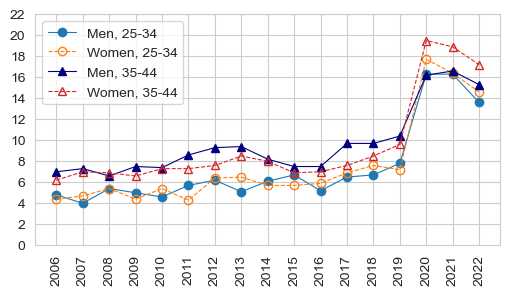

In [7]:
colors = sn.color_palette()
plt.figure(figsize=(6,3))
plt.plot(100-tab["Men",'De 25 a 34 años',"Ningún día"],label='Men, 25-34',marker='o',lw=0.8)
plt.plot(100-tab['Women',"De 25 a 34 años","Ningún día"],label='Women, 25-34',lw=0.8,marker='o',fillstyle='none',ls='--')

plt.plot(100-tab["Men",'De 35 a 44 años',"Ningún día"],label='Men, 35-44',lw=0.8,marker='^',c='navy')
plt.plot(100-tab['Women',"De 35 a 44 años","Ningún día"],label='Women, 35-44',lw=0.8,marker='^',fillstyle='none',ls='--',c=colors[3])
plt.xticks(rotation=90)
# plt.title('Remote work, percentage points')
plt.legend()
plt.ylim(0,22)
plt.yticks(np.arange(0,24,2))
plt.savefig('./descriptive_Stats/remote_work.pdf',format='pdf',bbox_inches='tight')
plt.show()

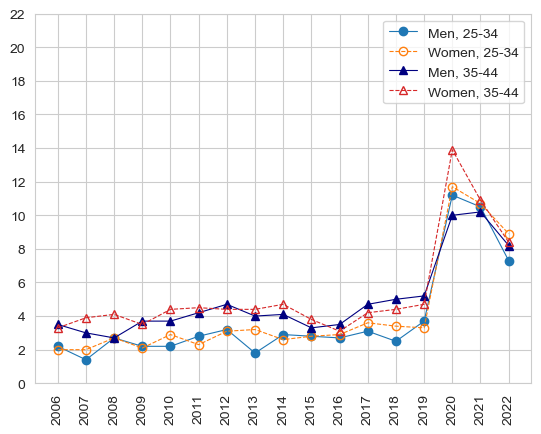

In [72]:
colors = sn.color_palette()
plt.plot(tab["Men",'De 25 a 34 años',"Más de la mitad de los días que trabajó"],label='Men, 25-34',marker='o',lw=0.8)
plt.plot(tab['Women',"De 25 a 34 años","Más de la mitad de los días que trabajó"],label='Women, 25-34',lw=0.8,marker='o',fillstyle='none',ls='--')

plt.plot(tab["Men",'De 35 a 44 años',"Más de la mitad de los días que trabajó"],label='Men, 35-44',lw=0.8,marker='^',c='navy')
plt.plot(tab['Women',"De 35 a 44 años","Más de la mitad de los días que trabajó"],label='Women, 35-44',lw=0.8,marker='^',fillstyle='none',ls='--',c=colors[3])
plt.xticks(rotation=90)
# plt.title('Remote work, percentage points')
plt.legend()
plt.ylim(0,22)
plt.yticks(np.arange(0,24,2))
# plt.savefig('./descriptive_Stats/remote_work.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Lives with the Grandmother

In [5]:
path = 'descriptive_stats/'

gran_10 = normalise_table(read_table(path+'grannies_10.log',rescale=100,ncols=2))
gran_10.index = gran_10.index.map(date_dict)

gran_5 = normalise_table(read_table(path+'grannies_5.log',rescale=100,ncols=2))
gran_5.index = gran_5.index.map(date_dict)
gran_10.head()

,0,1,Total
2005Q1,0.945067,0.054933,4169749.24
2005Q2,0.945372,0.054628,4208751.16
2005Q3,0.945690,0.054310,4246762.40
2005Q4,0.948276,0.051724,4270261.37
2006Q1,0.950539,0.049461,4297098.08


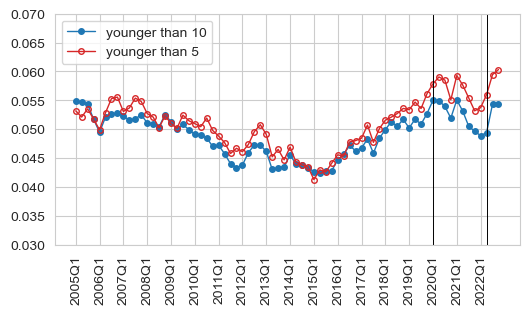

In [6]:
colors =sn.color_palette()
plt.figure(figsize=(6,3))
plt.plot(gran_10['1'],label='younger than 10',marker='o',ms=4,lw=1)
plt.plot(gran_5['1'],label='younger than 5',marker='o',fillstyle='none',color=colors[3],ms=4,lw=1)
plt.xticks(gran_10.index[::4],rotation=90)
plt.ylim(0.03,0.07)
plt.yticks(np.arange(0.03,0.075,0.005))
plt.axvline('2020Q1',c='k',lw=0.7)
plt.axvline('2022Q2',c='k',lw=0.7)
plt.legend()
plt.savefig(path+'share_grandmother.pdf',format='pdf',bbox_inches='tight')
plt.show()